In [7]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

# GPU support
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

<h1>
<center>A3T-GCN: Attention Temporal Graph
Convolutional Network for Traffic Forecasting</center>
</h1>


## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network

- 一共有207个传感器收集的数据(主要就是速度信息)
- 这些传感器在洛杉矶每5分钟收集一次数据

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
#输入12个样本点 预测未来12个点的值
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x000001D0A6A31DC0>


#### Data Sample
- 207 nodes 传感器
- 2 features per node (speed, time) 每个具有两个特征
- 12 timesteps per bucket (12 x 5 min = 60 min) 输入是12个时间点
- Labels for 12 future timesteps (normalized speed) --> node regression 标签是未来12个点的速度值
- Edge_attr is build based on the distances between sensors + threshold（阈值）
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

In [4]:
# 通过遍历来计算样本数量
sample_count = sum(1 for _ in dataset)
print("Number of samples / sequences: ", sample_count)
# 数据样例
first_sample = next(iter(dataset))
print(first_sample)

Number of samples / sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


x=[207, 2, 12] ==>> 207个节点（摄像头）；节点的两个特征（speed, time）；两个特征在12个时间序列中的特征值

edge_index=[2, 1722] ===>>2：应于边的起点索引和终点索引；1722：图中总共有1722条边

edge_attr=[1722] ===>> 每条边的特征值：基于 传感器之间的距离和阈值 构建

y=[207, 12]) ===>> 207个节点未来12个点的速度值

In [5]:
# X: 查看第一个节点的所有特征
print("Features of the first node:\n", first_sample.x[0, :])

Features of the first node:
 tensor([[ 0.5332,  0.4486,  0.5146, -2.6522, -2.6522,  0.1847,  0.6383,  0.4961,
          0.7497,  0.4899,  0.5751,  0.4280],
        [-1.7292, -1.7171, -1.7051, -1.6930, -1.6810, -1.6689, -1.6569, -1.6448,
         -1.6328, -1.6207, -1.6087, -1.5966]])


In [6]:
# edge index
print("First sample edge index shape: ", first_sample.edge_index.shape)
print("First 5 rows of edge index features:\n", first_sample.edge_index[:, :])

First sample edge index shape:  torch.Size([2, 1722])
First 5 rows of edge index features:
 tensor([[  0,   0,   0,  ..., 206, 206, 206],
        [  0,  13,  37,  ..., 187, 198, 206]])


In [7]:
# y
print("First sample target shape: ", first_sample.y.shape)
print("First 1 rows of node features:\n", first_sample.y[:1, :])

First sample target shape:  torch.Size([207, 12])
First 1 rows of node features:
 tensor([[0.3724, 0.2452, 0.4961, 0.6521, 0.1126, 0.5311, 0.5091, 0.4713, 0.4218,
         0.3909, 0.4761, 0.5641]])


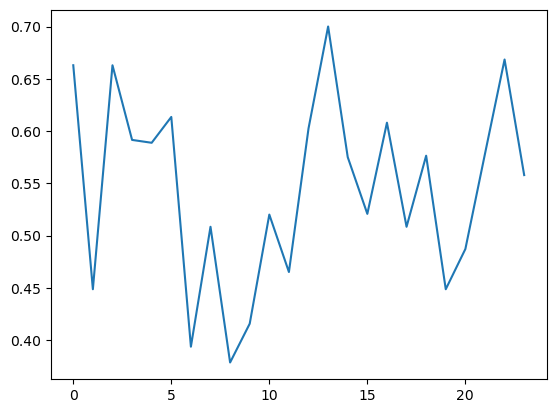

In [8]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)
plt.show()

# Test Train Split 数据集切分

In [25]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_dataset_count = sum(1 for _ in train_dataset)
test_dataset_count = sum(1 for _ in test_dataset)

print("Number of train buckets: ", train_dataset_count)
print("Number of test buckets: ", test_dataset_count)

print(train_dataset)
print(next(iter(train_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


# Creating DataLoaders
#### Parameters
edge_index (Numpy array) – Index tensor of edges.

edge_weight (Numpy array) – Edge weight tensor.

features (Sequence of Numpy arrays) – Sequence of node feature tensors.

targets (Sequence of Numpy arrays) – Sequence of node label (target) tensors.

**kwargs (optional Sequence of Numpy arrays) – Sequence of additional attributes.

In [27]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)

train_target = np.array(train_dataset.targets) # (27399, 207, 12)

train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)

train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)

train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

# print('train_x_tensor:',train_x_tensor.shape)

train_x_tensor: torch.Size([27399, 207, 2, 12])


In [11]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

## Model

Which model to choose depends on which time-series task you work on. 

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

<html>
<img src="https://i.ibb.co/WxrJQbc/a3tgcn.png", height="300"></img>

# TGCN model
A temporal GCN (T-GCN) model was constructed by combining GCN and GRU. 

n historical time series traffic data were inputted into the T-GCN model to obtain n hidden states (h) that covered spatiotemporal characteristics:{h(t−n), · · · , h(t−1), h(t)}


ut = σ(Wu ∗ (GC(A, Xt), ht−1)) 

rt = σ(Wr ∗ (GC(A, Xt), ht−1)) 

ct = tanh(Wc ∗ (GC(A, Xt), (rt ∗ ht−1)))

ht = ut ∗ ht−1 + (1 − ut) ∗ ct) 


Then, the hidden states were inputted into the attention model to determine the context vector that covers the global traffic variation information. Particularly, the weight of each h was calculated by Softmax using a multilayer perception:{at−n, · · · , at−1, at}.The context vector that covers global traffic variation information is calculated by the weighted sum. 


# A3TGCN Model
The A3TGCN is an extention of the TGCN model by adding an attention mechanism.

The attention mechanism was introduced to re-weight the influence of historical traffic states and thus to capture the global variation trends of traffic state

In [12]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h
    
#预测未来的12个值
TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## Training

In [13]:
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

# Loading the graph once 
because it's a static graph

In [14]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [20]:
model.train()

from tqdm.notebook import tqdm, trange

all_epoch_loss_list = []
# 循环遍历10个训练周期（epoch）。每个epoch都会遍历整个训练数据集一次
for epoch in tqdm(range(10),desc='Epochs'):
    step = 0
    loss_list = []
    # 循环遍历训练数据集中的每个样本（或称为快照）
    for encoder_inputs, labels in train_loader:
        # Get model predictions 模型的前向传递
        y_hat = model(encoder_inputs, static_edge_index)
        # 计算当前批次的均方误差（MSE）
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        # 反向传播。通过计算损失函数相对于模型参数的梯度来更新模型的权重。告诉模型如何通过调整参数来减少损失。
        loss.backward()
        # 更新模型的参数。在这一步中，优化器（optimizer）根据之前计算的梯度来更新模型的权重。
        optimizer.step()
        # 清零梯度。梯度会在每次.backward()调用时累积，因此在下一次迭代前需要手动清零。这确保了每次迭代的梯度计算只基于最新的一次迭代，而不是之前迭代的累积结果。
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
#         if step % 100 == 0 :
#             print(sum(loss_list)/len(loss_list))
    print("Epoch {} train MSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))
    all_epoch_loss_list.append(round(sum(loss_list)/len(loss_list),4))

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

0.4228931361436844
0.43394079595804214
0.4362882168094317
0.4372653069347143
0.44152264404296876
0.44286652659376463
0.4434243550470897
0.4447689437493682
Epoch 0 train MSE: 0.4423
0.437904514670372
0.4481500431895256
0.4442126742998759
0.445406624302268
0.4440049990415573
0.44347162038087845
0.44473747049059187
0.4421018037945032
Epoch 1 train MSE: 0.4423
0.4407471325993538
0.44693248480558395
0.4474923066298167
0.4477033820003271
0.4462487238645554
0.4414016616841157
0.4427385015147073
0.4428887842223048
Epoch 2 train MSE: 0.4425
0.4430389130115509
0.4350713428109884
0.44539299353957174
0.4480171151086688
0.44475149047374724
0.4445342809955279
0.44184135177305767
0.44213460363447665
Epoch 3 train MSE: 0.4423
0.44559069752693176
0.4538287082314491
0.4485314890742302
0.4480685770511627
0.44462179505825045
0.44384606103102364
0.44376107741679466
0.44505127491429447
Epoch 4 train MSE: 0.4425
0.42877707198262216
0.42843452133238313
0.4389013940592607
0.4421517600491643
0.44004563602805136

####  一个训练周期
- 0.7708807644248009
- 0.6375201033055782
- 0.5856399086117744
- 0.5634653544425965
- 0.5497353087067605
- 0.5394426196813583
- 0.5290417250990868
- 0.521105626411736

Epoch 0 train RMSE: 0.5200

Test MSE: 0.6012

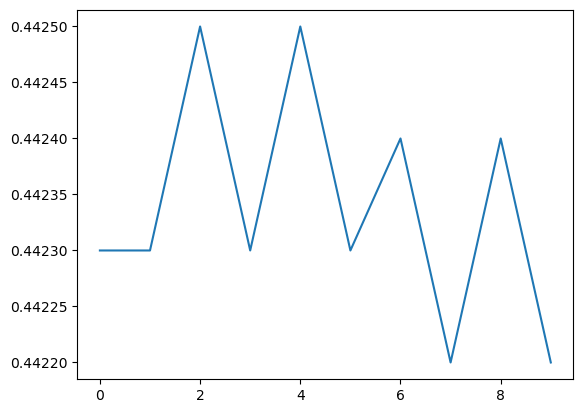

In [21]:
sns.lineplot(data=all_epoch_loss_list)
plt.show()

## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [22]:
# 将模型设置为评估模式
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.5444


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [29]:
sensor = 123
timestep = 11
# y_hat: torch.Size([32, 207, 12])
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

print('y_hat:',y_hat.shape)

Data points:, (32,)
y_hat: torch.Size([32, 207, 12])


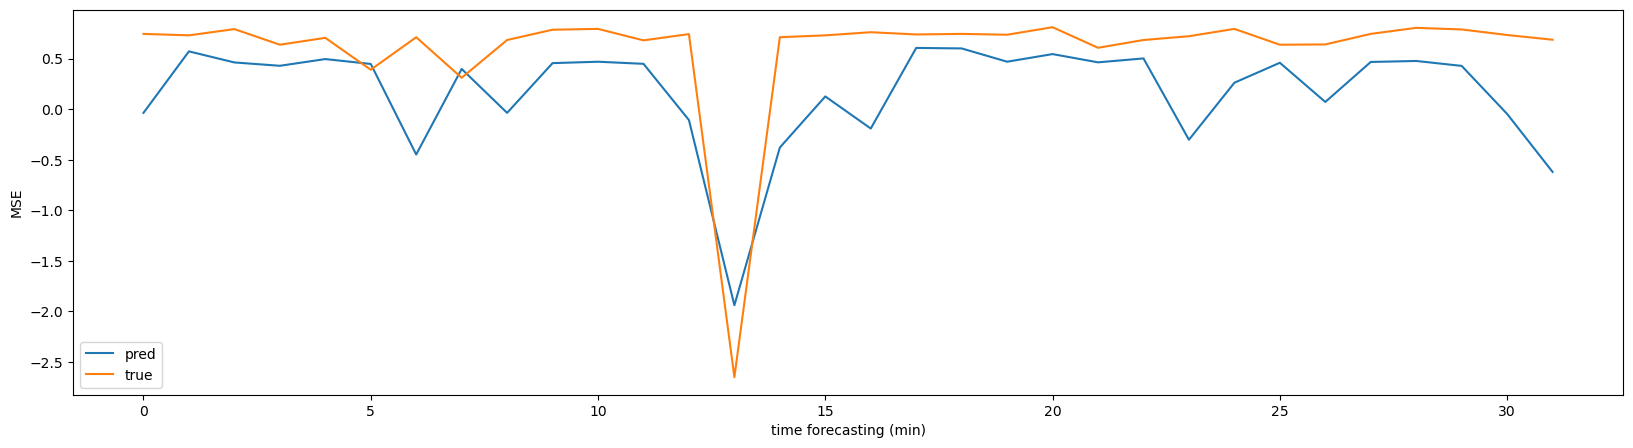

In [19]:
plt.figure(figsize=(20,5))
plt.ylabel('MSE')  # y轴标签
plt.xlabel('time forecasting (min)')  # y轴标签
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")
plt.show()